Задача 1 

Загрузка данных 

Данные для задачи загрузить из дополнительных материалов или по ссылке: https://www.kaggle.com/datasets/atanaskanev/sqlite-sakila-sample-database?select=SQLite3+Sakila+Sample+Database+ERD.png Выбрать СУБД PostgreSQL илиMySQL. Загрузить файлы базы данных как таблицы в выбранную СУБД. При загрузке таблиц обратить внимание на отношения между таблицами: первичные ключи (PrimaryKey) и внешние ключи (ForeignKey). После загрузки данных в таблицу проверить корректность типов данных и значений. Выгрузить dump базы данных.

In [113]:
#импорт необходимых для работы библиотек
import psycopg2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
#функция исполнения sql скрипта из файла

#исходные sql файлы скачанные с kaggle были мной отредактированны, двоичный тим даннх sqllite 
# одного из полей был заменен на двоичный тип postgresql bytea, также из файлов были удалены 
# лишние sql которые не нужны для выполнения задания (создание представлений запросов и 
# заполнение значений по умолчанию с помощью триггеров), также пришлось поменять последовательность 
# выполнения оставшихся скриптов

def run_sql_sqripts (file_name, dec=";"):
    with open(file_name, 'r') as file:
        query = file.read()
    query = query.split(dec)
    conn = psycopg2.connect(dbname="firstdb", user="denischeban", password="dengineering")
    cur = conn.cursor()
    for q in query:  
        try:
            cur.execute(q)
            conn.commit()
        except: 
            conn.rollback()
            continue
    cur.close()
    conn.close()
    file.close()


In [63]:
#создание базы
run_sql_sqripts (file_name="sqlite-sakila-schema.sql")

In [7]:
#заполнение базы данными
run_sql_sqripts (file_name="sqlite-sakila-insert-data.sql")

In [3]:
#создание резервной копии базы
damp_comand = "pg_dump -U denischeban firstdb > /Users/denischeban/python/innopolys_projects/project_1/firstdb.dump"
os.system(damp_comand)

0

In [ ]:
#удаление данных из базы (запускать при необходимости, перед запуском раскоментировать код)
#run_sql_sqripts (file_name="sqlite-sakila-delete-data.sql")

In [ ]:
#удаление базы (запускать при необходимости, перед запуском раскоментировать код)
#run_sql_sqripts (file_name="sqlite-sakila-drop-objects.sql")

Задача 2 

Подключение к БД и выполнение запросов

Внимательно изучить схему данных и загруженную базу из Задания1. Сформировать 1 или несколько классов по таблицам в базе данных.Подключиться к базе данных, загруженной в задаче 1 из python. При подключении рекомендуется использовать менеджер контекста. Выполнить запросы к данным для ответа на следующие вопросы и выгрузить в промежуточные таблицы: 

1. Какова доля фильмов в каждой рейтинговой категории (G,PG,PG-13,Rит.д.) в нашем ассортименте ?

2. Какие категории фильмов чаще всего арендуются клиентами?

3. Какова средняя продолжительность проката (rentalduration) для каждой категории фильмов? 

4. Каковы тенденции в ежемесячном доходе от проката (monthlyrentalrevenue) и продажах (sales) за прошедший год?

5. Как соотносятся показатели продаж в разных магазинах? 

6. Каковы средние затраты на замену (replacement_cost) фильмов в разных жанрах?

7. Какие актеры снимаются в самых разных жанрах фильмов? 

Результат выполненияз апросов сохранить в файлах.csv. Построить визуализации результатов запросов спомощью библиотек matplotlib,seaborn или plotl

In [19]:
#функция преобразующая результат sql запроса в датафрейм pandas
def sql_to_dataframe(query):
    conn = psycopg2.connect(dbname="firstdb", user="denischeban", password="dengineering")
    try:
        with conn.cursor() as cursor:
            df = pd.read_sql(query, conn, ) 
    finally:
        conn.close()
    return df

1. Какова доля фильмов в каждой рейтинговой категории (G,PG,PG-13,Rит.д.) в нашем ассортименте ?

In [ ]:
df = sql_to_dataframe('SELECT rating FROM film') #сформируем датафрейм по результатам sql запроса
df = df.groupby('rating')['rating'].count() #сгруппируем данные по рейтингу фильма
print(df) # выведем на экран количество фильмов по каждой рейтинговой категории
df.to_csv('rating_count.csv', sep=',', encoding='utf-8') #сохраним данные в файл

rating
G        178
NC-17    210
PG       194
PG-13    223
R        195
Name: rating, dtype: int64


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


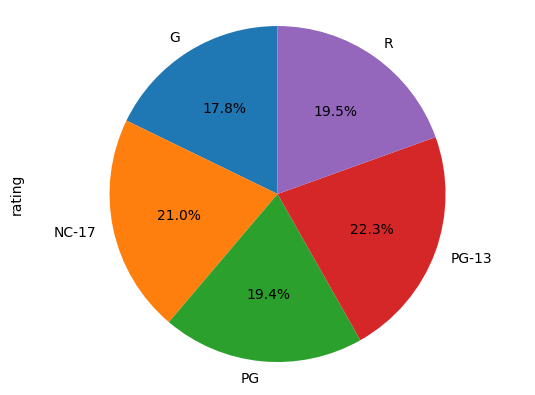

In [57]:
#выведем на экран круговую диаграмму с процентными долями фильмов в каждой рейтинговой категории в нашем ассортименте
df.plot.pie(y='rating', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()


2. Какие категории фильмов чаще всего арендуются клиентами?

In [65]:
print(df.sort_values(ascending=False)) #отсортируем данные 
df.to_csv('rating_count_sorted.csv', sep=',', encoding='utf-8') #сохраним данные в файл

rating
PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64


Чаще  всего арендуются фильмы с рейтингом PG-13

3. Какова средняя продолжительность проката (rentalduration) для каждой категории фильмов?

In [93]:
df_1 = sql_to_dataframe('SELECT category_id, name FROM category') #сформируем датафрейм по результатам sql запроса
df_2 = sql_to_dataframe('SELECT film_id, category_id FROM film_category') #сформируем датафрейм по результатам sql запроса
df_3 = sql_to_dataframe('SELECT film_id, rental_duration FROM film') #сформируем датафрейм по результатам sql запроса
df_2 = df_2.merge(df_3, on='film_id') #объеденим таблицы
df_2 = df_2.merge(df_1, on='category_id') #объеденим таблицы
#сгруппируем данные по категориям фильма рассчитав среднюю продолжительность проката для каждой категории
df_2 = df_2.groupby('name')['rental_duration'].mean() 
df_2.to_csv('rentalduration_in_filmcategory.csv', sep=',', encoding='utf-8') #сохраним данные в файл

/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


In [94]:
print(df_2)

name
Action         4.953125
Animation      4.893939
Children       5.033333
Classics       5.070175
Comedy         4.931034
Documentary    4.764706
Drama          5.080645
Family         5.173913
Foreign        5.109589
Games          5.065574
Horror         4.857143
Music          5.235294
New            4.746032
Sci-Fi         4.885246
Sports         4.716216
Travel         5.350877
Name: rental_duration, dtype: float64


<Axes: xlabel='Категория фильма', ylabel='Средняя продолжительность аренды'>

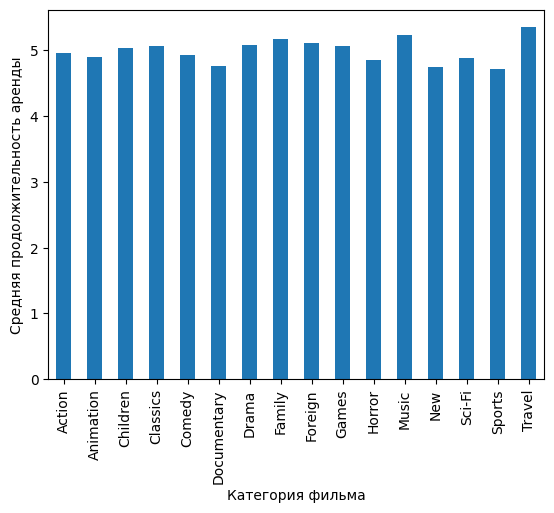

In [100]:
df_2.plot.bar(xlabel='Категория фильма', ylabel='Средняя продолжительность аренды')

4. Каковы тенденции в ежемесячном доходе от проката (monthlyrentalrevenue - доход от продаж) и продажах (sales - количество продаж) за прошедший год?

In [179]:
data = sql_to_dataframe('SELECT payment_date, amount FROM payment') #сформируем датафрейм по результатам sql запроса
data['payment_date'] = pd.to_datetime(data['payment_date'])
data = data.set_index(data.payment_date)
data = data.drop(columns=['payment_date'])


print(data)

                     amount
payment_date               
2005-05-25 11:30:37    2.99
2005-05-28 10:35:23    0.99
2005-06-15 00:54:12    5.99
2005-06-15 18:02:53    0.99
2005-06-15 21:08:46    9.99
...                     ...
2005-08-21 17:43:42    4.99
2005-08-21 21:41:57    1.99
2005-08-23 06:09:44    8.99
2005-08-23 11:08:46    2.99
2005-08-23 11:25:00    2.99

[16049 rows x 1 columns]


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


In [180]:
data.to_csv('time_stamp_data_sale.csv', sep=',', encoding='utf-8') #сохраним данные в файл
data_month_sum = data
data_month_sum = data_month_sum.resample('M').sum()


In [181]:
print(data_month_sum)

                amount
payment_date          
2005-05-31     4824.43
2005-06-30     9631.88
2005-07-31    28373.89
2005-08-31    24072.13
2005-09-30        0.00
2005-10-31        0.00
2005-11-30        0.00
2005-12-31        0.00
2006-01-31        0.00
2006-02-28      514.18


<Axes: xlabel='payment_date'>

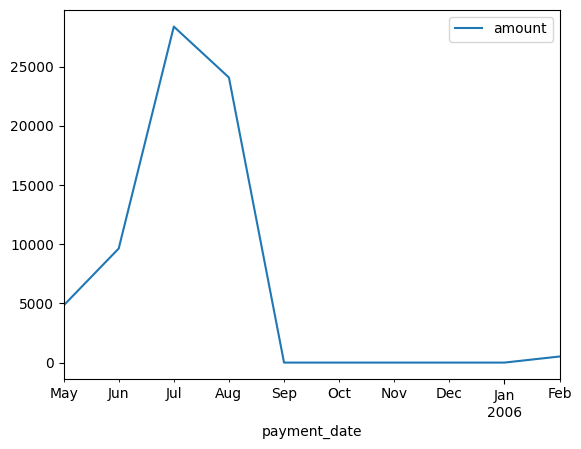

In [182]:
data_month_sum.plot()

Наблюдается резкое снижение выручки с июля по сентябрь, после чего выручка на протяжении 4 месяцев нулевая. В феврале незначительные поступления.

In [185]:
data_month_count = data
data_month_count = data_month_count.resample('M').count()
print(data_month_count)


              amount
payment_date        
2005-05-31      1157
2005-06-30      2312
2005-07-31      6711
2005-08-31      5687
2005-09-30         0
2005-10-31         0
2005-11-30         0
2005-12-31         0
2006-01-31         0
2006-02-28       182


<Axes: xlabel='payment_date'>

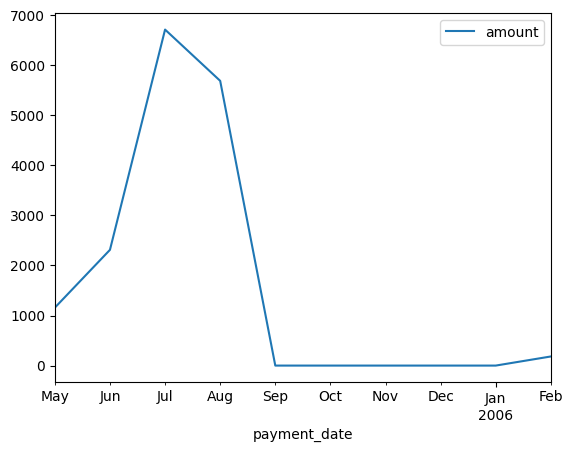

In [184]:
data_month_count.plot()

Аналогичная картина наблюдается на графике количества (транзакций по обмену дисков). В 2005 году появился youtube, а с октября 2005 он стал пинадлежать google, взможно, падение количества транзакций по обмену дисков связано с повышением доступности контента с youtube.

5. Как соотносятся показатели продаж в разных магазинах?

In [187]:
data_stores = sql_to_dataframe('SELECT staff_id, amount FROM payment') #сформируем датафрейм по результатам sql запроса
data_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16049 entries, 0 to 16048
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   staff_id  16049 non-null  int64  
 1   amount    16049 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 250.9 KB


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


исходя из структуры данных можно сделать вывод, что в каждом магазине работатет свой сотрудник, закрепленный за данным магазином, поэтому выгрузим таблицу с данными о персонале и объеденим ее с выгрузкой с таблицей продаж по столбцу staff_id

In [188]:
data_stores_1 = sql_to_dataframe('SELECT staff_id, store_id FROM staff') #сформируем датафрейм по результатам sql запроса
data_stores_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   staff_id  2 non-null      int64
 1   store_id  2 non-null      int64
dtypes: int64(2)
memory usage: 160.0 bytes


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


In [189]:
data_stores = data_stores.merge(data_stores_1, on='staff_id') #объеденим таблицы
data_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16049 entries, 0 to 16048
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   staff_id  16049 non-null  int64  
 1   amount    16049 non-null  float64
 2   store_id  16049 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 376.3 KB


store_id
1    33489.47
2    33927.04
Name: amount, dtype: float64


<Axes: xlabel='Идентификационный номер магазина', ylabel='Общая сумма продаж'>

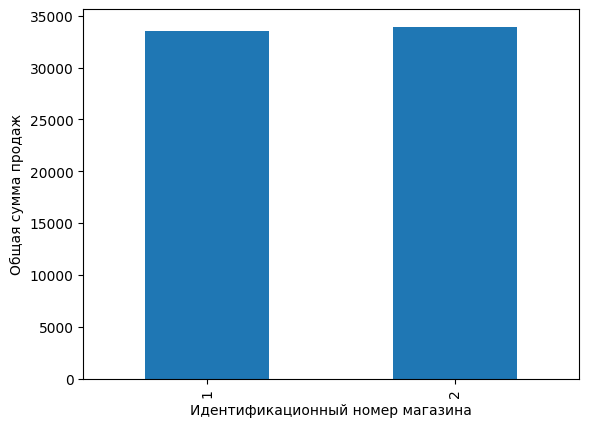

In [194]:
sum_store = data_stores.groupby('store_id')['amount'].sum()
print(sum_store)
sum_store.plot.bar(xlabel='Идентификационный номер магазина', ylabel='Общая сумма продаж')

store_id
1    8057
2    7992
Name: amount, dtype: int64


<Axes: xlabel='Идентификационный номер магазина', ylabel='Количество продаж'>

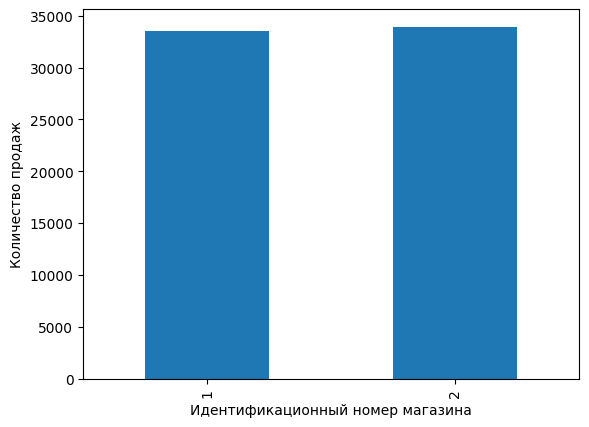

In [195]:
count_store = data_stores.groupby('store_id')['amount'].count()
print(count_store)
sum_store.plot.bar(xlabel='Идентификационный номер магазина', ylabel='Количество продаж')

Как видно сумма продаж и количество продаж почти одинаково в обоих магазинах, по которым есть данные

6. Каковы средние затраты на замену (replacement_cost) фильмов в разных жанрах?

In [212]:
data_frc = sql_to_dataframe('SELECT film_id, replacement_cost FROM film') #сформируем датафрейм по результатам sql запроса
print(data_frc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1000 non-null   int64  
 1   replacement_cost  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB
None


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


In [213]:
data_frc_1 = sql_to_dataframe('SELECT film_id, category_id FROM film_category') #сформируем датафрейм по результатам sql запроса
print(data_frc_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   film_id      1000 non-null   int64
 1   category_id  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB
None


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


In [214]:
data_frc_2 = sql_to_dataframe('SELECT category_id, name FROM category') #сформируем датафрейм по результатам sql запроса
print(data_frc_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category_id  16 non-null     int64 
 1   name         16 non-null     object
dtypes: int64(1), object(1)
memory usage: 384.0+ bytes
None


/var/folders/2x/1_8vzn5j1d5261pbvlmhrkdm0000gn/T/ipykernel_54003/1777515844.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, )


Объеденим таблицы:

In [215]:
#data_frc = data_frc.merge(data_frc_1, on='film_id') #объеденим таблицы
data_frc_1 = data_frc_1.merge(data_frc_2, on='category_id') #объеденим таблицы
data_frc_1 = data_frc_1.drop(columns=['category_id'])
data_frc = data_frc.merge(data_frc_1, on='film_id') #объеденим таблицы

In [217]:
data_frc = data_frc.drop(columns=['film_id'])
print(data_frc)

     replacement_cost         name
0               20.99  Documentary
1               12.99       Horror
2               18.99  Documentary
3               26.99       Horror
4               22.99       Family
..                ...          ...
995              9.99  Documentary
996             14.99        Music
997             10.99       Horror
998             28.99     Children
999             18.99       Comedy

[1000 rows x 2 columns]


In [219]:
data_frc = data_frc.groupby('name')['replacement_cost'].mean()
data_frc.to_csv('replacementcost_ingenre.csv', sep=',', encoding='utf-8')
print(data_frc)

name
Action         20.911875
Animation      20.126364
Children       20.056667
Classics       21.007544
Comedy         19.024483
Documentary    19.622353
Drama          21.086774
Family         19.729130
Foreign        18.647534
Games          20.285082
Horror         19.865000
Music          19.440980
New            19.418571
Sci-Fi         21.153934
Sports         20.395405
Travel         19.025088
Name: replacement_cost, dtype: float64


<Axes: xlabel='Жанр', ylabel='Средние затраты на замену'>

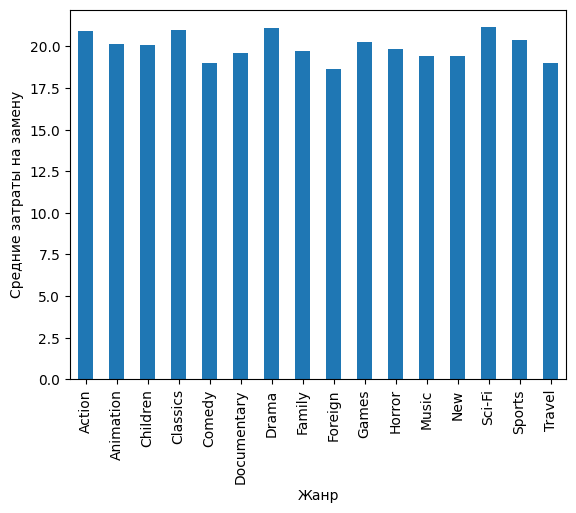

In [220]:
data_frc.plot.bar(xlabel='Жанр', ylabel='Средние затраты на замену')

7. Какие актеры снимаются в самых разных жанрах фильмов? 